In [14]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

import numpy as np
import pandas as pd
from vr2f.eyetracking import et_plot_gaze_saccades, ms_toolbox
from vr2f.staticinfo import COLORS, CONSTANTS, PATHS

paths = PATHS()
colors = COLORS()
constants = CONSTANTS()
cm = constants.CM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# read in the preprocessed data
pattern = "preproc.csv"

sub_list_str_et = [f for f in os.listdir(paths.DATA_ET_PREPROC) if pattern in f]
sub_list_str_et = [f.split("-")[0] for f in sub_list_str_et]
sub_list_str_et = np.unique(sorted(sub_list_str_et))

data_preproc = []
for sub_id in sorted(sub_list_str_et):
    fname = Path(paths.DATA_ET_PREPROC, f"{sub_id}-ET-{pattern}")
    df_clean = pd.read_csv(fname, sep=",")
    df_clean["sub_id"] = sub_id
    data_preproc.append(df_clean)

df_all = pd.concat(data_preproc, ignore_index=True)

You can plot the supplementary figures to visualize the gaze and the detected saccades for specific trials like this: 

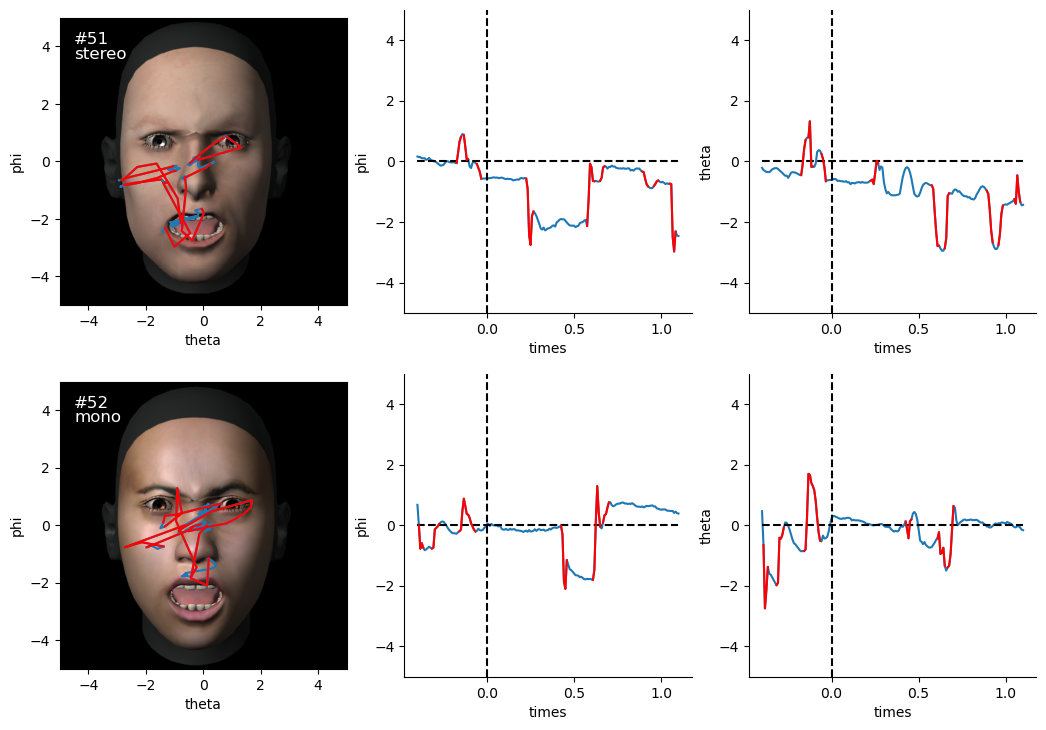

In [16]:

sub_id = "VR2FEM_S01"
trial_range = range(51, 53)
myfig = et_plot_gaze_saccades.plot_gaze_sacc_per_trial(df_all, sub_id, trial_range, sfreq=120)


To render PDFs (`results/figures/ET/Gaze_saccades`) with all trials for a given subject (or all of them), use the bash functionality of `et_plot_gaze_saccades.py` (ideally with the slurm script in `/code/HPC`). 

In [32]:
sub_id = "VR2FEM_S01"
sfreq = 120
vfac = 5
mindur = 3
min_sac_amp = 1

df_sub = (df_all.
            copy().
            query("sub_id == @sub_id")
)

df_o = pd.DataFrame()
trial_range = range(24,745)
for trial_idx in trial_range:
  df_st = get_data_sub_trialnum(df_sub, sub_id, trial_idx)
  data = df_st.loc[:,["theta", "phi"]].to_numpy()
  sac, rad = ms_toolbox.microsacc(data, srate=sfreq, vfac=vfac, mindur=mindur)
  sac["trial_num"] = trial_idx + 1
  df_o = pd.concat([df_o, sac], ignore_index=True)

In [47]:

times = df_sub["times"]
times
df_o["time_onset"] = df_o["idx_onset"].map(lambda x: times[x])
df_o["time_offset"] = df_o["idx_offset"].map(lambda x: times[x])
df_o["amp_tot"] = np.sqrt(df_o["amp_x"]**2 + df_o["amp_y"]**2) 

df_agg = df_o.groupby(["trial_num"]).agg({"amp_tot": ["count", "mean"]})
df_agg.columns = df_agg.columns.droplevel(0)
df_agg.columns = ["trial_num", "n_sac", "mean_sac_amp"]


/tmp/ipykernel_35137/319254142.py:8: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df_mm = df_sub.merge(df_agg, on=["trial_num"])


In [52]:
df_mm = (df_sub
          .groupby(["trial_num"])
          .first()
          .reset_index()
          .merge(df_agg, on=["trial_num"]))
df_mm

/tmp/ipykernel_35137/1232734028.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df_mm = (df_sub


,trial_num,level_0,index,time,timestamp_et,timestamp_lsl,direction_x_local,direction_y_local,direction_z_local,position_x_local,...,marker,viewcond,avatar_id,emotion,blink,theta_baseline,phi_baseline,sub_id,"(amp_tot, count)","(amp_tot, mean)"
0,24,5562,23,645.3820,1391231,5686.247132,-0.010605,-0.017944,0.999771,-0.000446,...,233,stereo,Woman_08,angry,False,-0.896599,0.812842,VR2FEM_S01,11,2.155359
1,25,5803,362,707.1563,1453001,5748.020156,0.135437,0.020004,0.990570,0.012213,...,122,mono,Woman_04,happy,False,-0.009306,-0.225854,VR2FEM_S01,8,2.912147
2,26,6044,24,712.6712,1458516,5753.536039,-0.011978,0.006897,0.999893,0.004437,...,224,stereo,Woman_04,surprised,False,-0.723849,-0.993154,VR2FEM_S01,9,2.126068
3,27,6285,22,718.2582,1464098,5759.118334,-0.005951,-0.006454,0.999954,-0.005276,...,131,mono,Woman_08,neutral,False,-1.456091,0.254742,VR2FEM_S01,6,2.260800
4,28,6526,22,723.2939,1469139,5764.159241,0.004395,-0.004196,0.999970,-0.004211,...,211,stereo,Woman_01,neutral,False,0.242540,0.349134,VR2FEM_S01,8,1.688803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,740,178118,24,6866.1160,3500148,12090.460342,0.003311,-0.010178,0.999939,-0.002157,...,122,mono,Woman_04,happy,False,0.251291,0.567412,VR2FEM_S01,5,1.013177
658,741,178359,23,6870.3610,3504389,12094.701317,-0.003693,-0.008163,0.999954,-0.002255,...,121,mono,Woman_04,neutral,False,-0.261273,0.701294,VR2FEM_S01,3,1.747658
659,742,178600,23,6875.5250,3509555,12099.867016,-0.007584,-0.005127,0.999954,-0.001216,...,124,mono,Woman_04,surprised,False,-0.273126,-0.130965,VR2FEM_S01,4,1.366729
660,743,178841,24,6881.4630,3515487,12105.799350,0.004059,-0.009979,0.999939,-0.000782,...,234,stereo,Woman_08,surprised,False,-1.269346,0.991796,VR2FEM_S01,6,1.359208
